# Project 2 Source Code

## Imports

In [1]:
import numpy as np
from scipy import ndimage as nd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize
from torch.nn.functional import conv2d, pad
import torch
from project2_cuda import corner_nms, ncc, harris_corner
from typing import Tuple, Union

## Convenience Methods

In [2]:
def rgb2gray(img: torch.Tensor):
    """
    Converts an RGB image to Grayscale
    :param img: the RGB image as a pytorch tensor
    :return: The image as grayscale
    """
    return torch.mean(img, dim=2)

def downscale(img: torch.Tensor, factor):
    """
    downscales the size of the given image by the given factor
    :param img: the image as a pytorch Tensor
    :param factor: the factor by which the dimensions of the input
    image will be downsampled by
    :return: the downscaled image as a pytorch Tensor
    """
    r, c = img.size()
    r = r // factor
    c = c // factor
    return resize(img.unsqueeze(0), [r, c]).squeeze()

def convolve2d(img: Union[np.ndarray, torch.Tensor], weight: Union[np.ndarray, torch.Tensor],
             padding: str = 'same') -> torch.Tensor:
    """
    A convenience function for convolving 2D images with 2D filters using Pytorch 2D convolution.
    Does not alter the device of the tensor, but converts the data type to torch.float32.
    :param img:
    :param weight:
    :param padding:
    :return:
    """
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).float()
    if isinstance(weight, np.ndarray):
        weight = torch.from_numpy(weight).float()

    assert len(img.shape) == 2 and len(weight.shape) == 2
    assert img.device == weight.device

    img = img.unsqueeze(0).unsqueeze(0)
    weight = weight.unsqueeze(0).unsqueeze(0)
    return conv2d(img, weight, padding=padding).squeeze()

## Noise Removal functions

In [3]:
# Box filter for smoothing
def box_filter(img: Union[np.ndarray, torch.Tensor], diameter: int, padding: str = 'same') -> torch.Tensor:
    """
    Applies box filter to the given image
    :param padding: Padding to be used for filtering
    :param img: Image of interest as a torch.Tensor
    :param diameter: the diameter of the box filter
    :return: filtered image.
    """
    box = torch.ones([diameter, diameter],
                     dtype=torch.float,
                     device=img.device) / diameter**2
    return convolve2d(img, box, padding)

def gaussian_filter(img: Union[np.ndarray, torch.Tensor], s_sigma: float, padding: str = 'same') -> torch.Tensor:
    filt_rad = int(np.floor(5 * s_sigma))
    offset = filt_rad // 2
    g_filt_2d = torch.zeros((filt_rad, filt_rad), dtype=torch.float32, device=img.device)
    for i in range(filt_rad):
        for j in range(filt_rad):
            g_filt_2d[i, j] = np.exp(-((i - offset)**2 + (j - offset)**2) / (2 * s_sigma**2))
    g_filt_2d = g_filt_2d / g_filt_2d.sum()
    return convolve2d(img, g_filt_2d, padding)

## Gradient Estimation Functions

In [4]:
def sobel_x(img: torch.Tensor, padding: str = 'same') -> torch.Tensor:
    """
    Computes the gradient of the image in the x-direction using
    a sobel filter.
    :param padding: padding type to use when applying the filter. Follows the convention of Pytorch padding types
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_x_filter = torch.tensor([[1., 0., -1.],
                                   [2., 0., -2.],
                                   [1., 0., -1.]], device=img.device)
    return convolve2d(img, sobel_x_filter, padding)


def sobel_y(img: torch.Tensor, padding: str = 'same'):
    """
    Computes the gradient of the image in the y-direction using
    a sobel filter.
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_y_filter = torch.tensor([[1., 2., 1.],
                                   [0., 0., 0.],
                                   [-1., -2., -1.]
                                   ], device=img.device)
    return convolve2d(img, sobel_y_filter, padding)


def estimate_gradient_dirs(img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    return sobel_x(img), sobel_y(img)

In [5]:
# Normalized Cross Correlation
def norm_cross_corr(img, filt):
    r,c = img.shape
    ncc = torch.zeros([r,c], device=img.device, dtype=torch.float32)
    filt_x_pad = filt.shape[0] // 2
    filt_y_pad = filt.shape[1] // 2
    padded = pad(img, [filt_x_pad, filt_y_pad, filt_x_pad, filt_y_pad],
                 'constant', 0)

    for i in range(r):
        for j in range(c):
            f = padded[i: i + filt.shape[0],
                       j: j + filt.shape[1]]
            len_f = torch.sqrt(torch.sum(f**2))
            if len_f == 0:
                norm_f = torch.zeros(f.shape)
            else:
                norm_f = f / len_f
            norm_g = filt / torch.sqrt(torch.sum(filt**2))
            ncc[i,j] = torch.dot(norm_f.flatten(), norm_g.flatten())
            
    return ncc


# Harris Corner Detector
def HarrisCorner(image, threshold, width, k):
    # remove corners that are near the edge
    def nearEdge(corners, width):

        r,c = corners.shape
        edge = (width - 1) // 2
        corners[0: edge, :] = 0
        corners[r-edge: r, :] = 0

        corners[:, 0: edge] = 0
        corners[:, c - edge: c] = 0

        return corners
    # Find gradients
    Ix = sobel_x(image)
    Iy = sobel_y(image)
    R =  harris_corner(Ix, Iy, width, k)
    # Ixx = Ix**2
    # Iyy = Iy**2
    #
    # # Compute R values
    # detM = Ixx * Iyy
    # traceM = Ixx + Iyy
    # R = detM - k * traceM**2

    # Threshold values
#     R[R < threshold * torch.max(R)] = 0
    
    # Nonmax Supression
    R = corner_nms(R, width)

    # Remove corners near the edge
#     R = nearEdge(R, width)

    return R


# Reduce threshold until ~1% of pixels are corners
def reducedHarris(image, width, k, density):

    threshold = 1.0
    ratio = density + 1
    while ratio >= density:
        threshold = 0.9 * threshold

        corners = HarrisCorner(image, threshold, width, k)
        # Number of corners
        # idx = torch.where(corners>0)
        # idx = torch.tensor(idx).T
        # ratio = image.numel() / idx.shape[0]
    
    # print('Corners:', idx.shape[0])

    return corners


# Draw lines between matches
def drawLines(image1,image2,matches,threshold):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        if matches[i,-1] >= threshold:
            plt.plot(y[i,:],x[i,:])
    plt.axis('off')
    
    return


# Normalized Cross Correlation of two equal shaped patches
def patchNCC(f,g):

    len_f = np.sqrt(np.sum(f**2))
    norm_f = f/len_f

    len_g = np.sqrt(np.sum(g**2))
    norm_g = g/len_g

    norm_f = np.reshape(norm_f,[1,f.size])
    norm_g = np.reshape(norm_g,[g.size,1])
    ncc = np.dot(norm_f,norm_g)
            
    return ncc


# Find matches from im1 to im2
def patch2patch(im1,im2,corners1,corners2,width,num_matches):

    # Patch from location
    def getPatch(im,r,c,width):
        left = int( (width-1)/2 )
        right = int( (width-1)/2 + 1 )
        patch = im[r-left:r+right,c-left:c+right]
        return patch

    def cornerCoord(corners):
        idx = np.where(corners>0)
        idx = np.array(idx).T
        return idx

    # Find patch coordinates
    coord1 = cornerCoord(corners1)
    coord2 = cornerCoord(corners2)

    matches = np.zeros([num_matches,5])
    
    i = 0
    while i<num_matches:
        r1 = coord1[i,0]
        c1 = coord1[i,1]
        match = np.array([r1,c1,0,0,0])
  
        # Match the patch to second image
        patch1 = getPatch(im1,r1,c1,width)
    
        for j in range(coord2.shape[0]):
            r2 = coord2[j,0]
            c2 = coord2[j,1]
            patch2 = getPatch(im2,r2,c2,width)

            ncc = patchNCC(patch1,patch2)
            if ncc >= match[4]:
                match = [r1,c1,r2,c2,ncc]

        matches[i,:] = match
        i+=1

    return matches

# Load Image, Reduce Size, Convert to Gray

In [6]:
# Load image1
file = 'DanaHallWay1/DSC_0282.JPG'
file = 'DanaOffice/DSC_0308.JPG'
image1 = torch.tensor(np.array(Image.open(file)), dtype=torch.float32).cuda()


# resize = torch.max(image.) / 100
#
# # Reduce resolution
gray1 = rgb2gray(image1)
gray1 = downscale(gray1, 1)
# Convert to grayscale


# Load image2
file = 'DanaHallWay1/DSC_0283.JPG'
file = 'DanaOffice/DSC_0309.JPG'
image2 = torch.tensor(np.array(Image.open(file)), dtype=torch.float32).cuda()
# Reduce resolution
gray2 = rgb2gray(image2)
gray2 = downscale(gray2, 1)
# Convert to grayscale


# Add blurring to reduce noise level

In [7]:
# Smooth image
blur = 3
im1 = gaussian_filter(gray1, 1, 'same')
im2 = gaussian_filter(gray2, 1, 'same')

Finding corners...
1
2
torch.Size([340, 512]) torch.Size([340, 512])


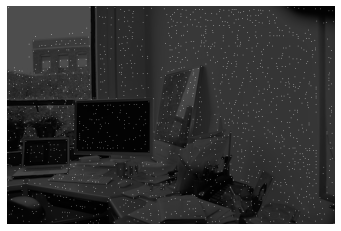

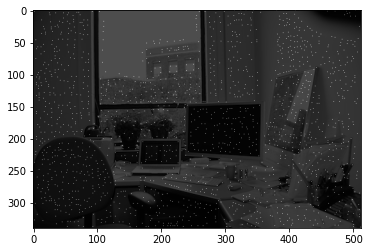

In [10]:
# Find sparse corners
print('Finding corners...')
width = 2
k = 0.04
density = 100
corners1 = HarrisCorner(im1, 0.7, width,k)
# print(corners1.max())
# corners1[corners1 <= corners1.amax() * 0.02] = 0
print("1")
corners2 = HarrisCorner(im2, 0.7, width,k)
# corners2[corners2 <= corners2.amax() * 0.02] = 0
print("2")
Ix = sobel_x(gray1)
Iy = sobel_y(gray1)

plt.imshow(gray1.cpu().numpy(),cmap='gray')
plt.imshow(corners1.cpu().numpy()>0,cmap='gray',alpha=0.7)
# plt.imshow((torch.sqrt(Ix**2 + Iy**2)).cpu().numpy(), cmap='gray', alpha =1.0)
print(corners1.shape, gray1.shape)
plt.axis('off')
plt.savefig('k0600.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(gray2.cpu().numpy(),cmap='gray')
plt.imshow(corners2.cpu().numpy()>0,cmap='gray',alpha=0.7)
plt.show()

In [83]:
print((corners1 > 0).sum())

tensor(87, device='cuda:0')


31704596.0


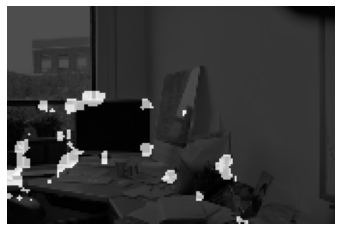

29869612.0


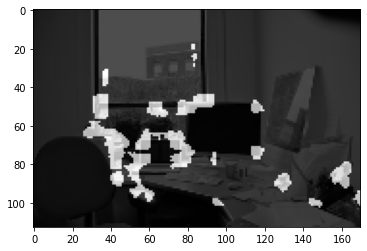

In [105]:
import cv2
c_cv2 = cv2.cornerHarris(gray1.cpu().numpy(), 9, 3, 0.04)
print(c_cv2.max())
plt.imshow(gray1.cpu().numpy(),cmap='gray')
plt.imshow(c_cv2 > 0.1 * c_cv2.max(),cmap='gray',alpha=0.7)
plt.axis('off')
plt.show()
c_cv2_2 = cv2.cornerHarris(gray2.cpu().numpy(), 9, 3, 0.04)
print(c_cv2_2.max())
plt.imshow(gray2.cpu().numpy(),cmap='gray')
plt.imshow(c_cv2_2 > 0.1 * c_cv2_2.max(),cmap='gray',alpha=0.7)
plt.show()

In [72]:
def findCorners(img, window_size, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    color_img = np.zeros_like(img).astype(np.int)
    offset = window_size//2

    #Loop through image and find our corners
    print("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
#                 print(x, y, r)
                color_img[y, x] = 255
#                 cornerList.append([x, y, r])
#                 color_img.itemset((y, x), 255)
#                 color_img.itemset((y, x, 1), 0)
#                 color_img.itemset((y, x, 2), 255)
    return color_img
    return color_img, cornerList

Finding corners...
Finding Corners...


/tmp/ipykernel_3707/1370151279.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color_img = np.zeros_like(img).astype(np.int)


255
1
Finding Corners...
2
(56, 85) torch.Size([56, 85])


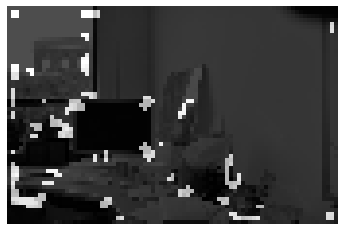

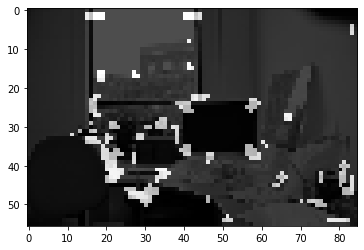

In [79]:
# Find sparse corners
print('Finding corners...')
width = 3
k = 0.04
density = 100
corners1 = findCorners(im1.cpu().numpy(), width,k, 2000000)
print(corners1.max())
# corners1[corners1 <= corners1.max() * 0.02] = 0
print("1")
corners2 = findCorners(im2.cpu().numpy(), width,k, 2000000)
# corners2[corners2 <= corners2.max() * 0.02] = 0
print("2")
print(corners1.shape, gray1.shape)

plt.imshow(gray1.cpu().numpy(),cmap='gray')
plt.imshow(corners1,cmap='gray',alpha=0.7)

plt.axis('off')
plt.savefig('k0600.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(gray2.cpu().numpy(),cmap='gray')
plt.imshow(corners2,cmap='gray',alpha=0.7)
plt.show()

In [70]:
# Find matches
print('Finding matches...')
num_matches = torch.sum(corners1>0)
print("")
matches = patch2patch(im1,im2,corners1,corners2,width,num_matches)
print(matches.shape[0],'matches found.')
drawLines(gray1,gray2,matches,0.95)

Finding matches...


TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
print(matches)